In [1]:
# LSTM test for BMI project
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import CCA
from sklearn.manifold import Isomap
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge, LinearRegression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import seaborn as sns
from tqdm.auto import tqdm
import os
import umap
from scipy import linalg
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import accuracy_score

from pyaldata import *

# If you would prefer to load the '.h5' example file rather than the '.pickle' example file. You need the deepdish package
# import deepdish as dd 

#Import function to get the covariate matrix that includes spike history from previous bins
from Neural_Decoding.preprocessing_funcs import get_spikes_with_history

#Import metrics
from Neural_Decoding.metrics import get_R2
from Neural_Decoding.metrics import get_rho

#Import decoder functions
from Neural_Decoding.decoders import WienerCascadeDecoder
from Neural_Decoding.decoders import WienerFilterDecoder
from Neural_Decoding.decoders import DenseNNDecoder
from Neural_Decoding.decoders import SimpleRNNDecoder
from Neural_Decoding.decoders import GRUDecoder
from Neural_Decoding.decoders import LSTMDecoder
from Neural_Decoding.decoders import XGBoostDecoder
from Neural_Decoding.decoders import SVRDecoder

In [2]:

data = scipy.io.loadmat('monkeydata_training.mat')
pred_class = scipy.io.loadmat('pred_class.mat')
bins_before=6 #How many bins of neural data prior to the output are used for decoding
bins_current=1 #Whether to use concurrent time bin of neural data
bins_after=6 #How many bins of neural data after the output are used for decoding

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN, Created on: Wed Feb 23 20:58:57 2011', '__version__': '1.0', '__globals__': [], 'trial': array([[(array([[111]], dtype=uint8), array([[1, 0, 0, ..., 0, 0, 0],
               [0, 0, 0, ..., 0, 0, 0],
               [0, 0, 0, ..., 0, 0, 0],
               ...,
               [0, 0, 0, ..., 0, 0, 0],
               [0, 0, 0, ..., 0, 0, 0],
               [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), array([[-13.47083333, -13.46852386, -13.46541717, ...,  75.65101817,
                 75.67271444,  75.69340087],
               [ -8.0225    ,  -8.02420787,  -8.02519673, ...,  45.41279603,
                 45.36416882,  45.31664636],
               [-17.89333333, -17.89299333, -17.89293732, ..., -18.11325884,
                -18.11279044, -18.11238267]]))                                                                             ,
        (array([[78]], dtype=uint8), array([[0, 0, 0, ..., 0, 0, 0],
               [0, 0, 0, ..., 0, 0, 0],
    

Text(62.5, 0.5, 'True Class')

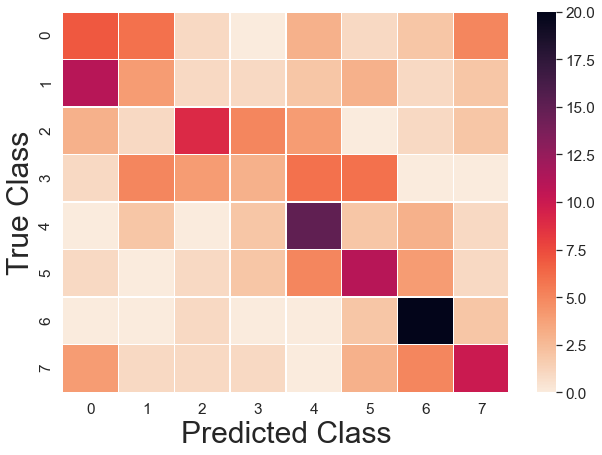

In [7]:
m = scipy.io.loadmat('m.mat')
target = scipy.io.loadmat('target.mat')
results = scipy.io.loadmat('results.mat')
target = target['ideal_test']
results = results['res_test']
from sklearn.metrics import confusion_matrix
m = confusion_matrix(target[0], results[0])

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(m, range(8), range(8))
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
p = sn.heatmap(df_cm,linewidths=.5, cmap="rocket_r") # font size


p.set_xlabel("Predicted Class", fontsize = 30)
p.set_ylabel("True Class", fontsize = 30)

Text(62.5, 0.5, 'True Class')

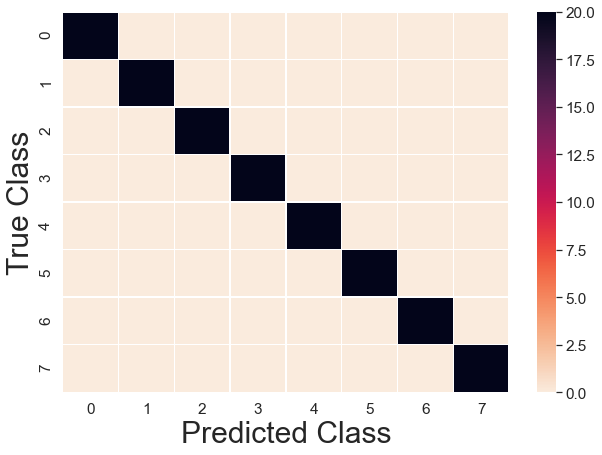

In [8]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

array = [[20,0,0,0,0,0,0,0],
         [0,20,0,0,0,0,0,0],
         [0,0,20,0,0,0,0,0],
         [0,0,0,20,0,0,0,0],
         [0,0,0,0,20,0,0,0],
         [0,0,0,0,0,20,0,0],
         [0,0,0,0,0,0,20,0],
         [0,0,0,0,0,0,0,20]]

df_cm = pd.DataFrame(array, range(8), range(8))
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
p = sn.heatmap(df_cm,linewidths=.5, cmap="rocket_r") # font size


p.set_xlabel("Predicted Class", fontsize = 30)
p.set_ylabel("True Class", fontsize = 30)

56.35229784671856
57.60760578164661
58.68825943105824
58.85812056283727
58.135302646956674
55.71799726896857
53.00619927675013
55.71113742834196


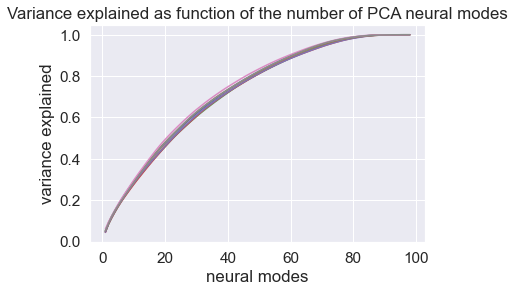

In [15]:

data1 = scipy.io.loadmat('concat_fr_lowstd.mat')
data2 = data1['concat_rate_trials']
for i in range(8):
    
    data = data2[0][i]
    from sklearn.decomposition import PCA
    pca = PCA(n_components=98)
    pca.fit(data)

    for i in range(len( pca.explained_variance_ratio_ )):
        if(i == 0):
            pca.explained_variance_ratio_[i] = pca.explained_variance_ratio_[i]
        else:
            pca.explained_variance_ratio_[i] = pca.explained_variance_ratio_[i] + pca.explained_variance_ratio_[i-1]
    t = list(range(1,99))
    plt.plot(t,pca.explained_variance_ratio_, linestyle='solid')
    print(np.sum(pca.explained_variance_) ** 2 / np.sum(pca.explained_variance_ ** 2))
plt.xlabel("neural modes")
plt.ylabel("variance explained")
plt.title("Variance explained as function of the number of PCA neural modes")

plt.show()

In [121]:
from sklearn.model_selection import train_test_split
data3 = data2[0][0]
pca = PCA(n_components=60)
pca.fit(data3)
data = data3@ np.transpose(pca.components_)

pos1 = scipy.io.loadmat('concat_handpos.mat')
pos2 = pos1['concat_pos_trials']
y = pos2[0][0]

bins_before=6 #How many bins of neural data prior to the output are used for decoding
bins_current=1 #Whether to use concurrent time bin of neural data
bins_after=6 #How many bins of neural data after the output are used for decoding

# Format for recurrent neural networks (SimpleRNN, GRU, LSTM)
# Function to get the covariate matrix that includes spike history from previous bins
X=get_spikes_with_history(data,bins_before,bins_after,bins_current)

# Format for Wiener Filter, Wiener Cascade, XGBoost, and Dense Neural Network
#Put in "flat" format, so each "neuron / time" is a single feature
X_flat=X.reshape(X.shape[0],(X.shape[1]*X.shape[2]))
#Set what part of data should be part of the training/testing/validation sets
training_range=[0, 0.7]
testing_range=[0.7, 0.85]
valid_range=[0.85,1]

num_examples=X.shape[0]

#Note that each range has a buffer of"bins_before" bins at the beginning, and "bins_after" bins at the end
#This makes it so that the different sets don't include overlapping neural data
training_set=np.arange(np.int(np.round(training_range[0]*num_examples))+bins_before,np.int(np.round(training_range[1]*num_examples))-bins_after)
testing_set=np.arange(np.int(np.round(testing_range[0]*num_examples))+bins_before,np.int(np.round(testing_range[1]*num_examples))-bins_after)
valid_set=np.arange(np.int(np.round(valid_range[0]*num_examples))+bins_before,np.int(np.round(valid_range[1]*num_examples))-bins_after)

#Get training data
X_train=X[training_set,:,:]
X_flat_train=X_flat[training_set,:]
y_train=y[training_set,:]

#Get testing data
X_test=X[testing_set,:,:]
X_flat_test=X_flat[testing_set,:]
y_test=y[testing_set,:]

#Get validation data
X_valid=X[valid_set,:,:]
X_flat_valid=X_flat[valid_set,:]
y_valid=y[valid_set,:]

#Z-score "X" inputs. 
X_train_mean=np.nanmean(X_train,axis=0)
X_train_std=np.nanstd(X_train,axis=0)
X_train=(X_train-X_train_mean)/X_train_std
X_test=(X_test-X_train_mean)/X_train_std
X_valid=(X_valid-X_train_mean)/X_train_std

#Z-score "X_flat" inputs. 
X_flat_train_mean=np.nanmean(X_flat_train,axis=0)
X_flat_train_std=np.nanstd(X_flat_train,axis=0)
X_flat_train=(X_flat_train-X_flat_train_mean)/X_flat_train_std
X_flat_test=(X_flat_test-X_flat_train_mean)/X_flat_train_std
X_flat_valid=(X_flat_valid-X_flat_train_mean)/X_flat_train_std

#Zero-center outputs
y_train_mean=np.mean(y_train,axis=0)
y_train=y_train-y_train_mean
y_test=y_test-y_train_mean


<ipython-input-121-1f7d231b49f5>:31: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  training_set=np.arange(np.int(np.round(training_range[0]*num_examples))+bins_before,np.int(np.round(training_range[1]*num_examples))-bins_after)
<ipython-input-121-1f7d231b49f5>:32: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish t

In [124]:
#Declare model
model_lstm=LSTMDecoder(units=400,dropout=0,num_epochs=5)

#Fit model
model_lstm.fit(X_train,y_train)

#Get predictions
y_valid_predicted_lstm=model_lstm.predict(X_valid)

#Get metric of fit
R2s_lstm=get_R2(y_valid,y_valid_predicted_lstm)
print('R2s:', R2s_lstm)

R2s: [  0.46517383   0.35201953 -35.11560169]


In [79]:
#Get predictions
y_valid_predicted_lstm=model_lstm.predict(X_valid)

#Get metric of fit
R2s_lstm=get_R2(y_valid,y_valid_predicted_lstm)
print('R2s:', R2s_lstm)

R2s: [0.71328607 0.10723056 0.45722057]


In [112]:
rmse_x = sqrt(np.mean(np.sum((y_valid_predicted_lstm[:,1] - y_valid[:,1] ) ** 2) / np.sum(y_valid[:,1]))
#rmse_y = sqrt(np.mean(np.sum((y_valid_predicted_lstm[:,2] - y_valid[:,2] ) ** 2) / np.sum(y_valid[:,2])))

SyntaxError: unexpected EOF while parsing (<ipython-input-112-c1fb5505aafa>, line 2)

In [61]:
rmse_x =abs(np.mean(np.sum((y_valid_predicted_lstm[:,1] - y_valid[:,1] ) ** 2) / np.sum(y_valid[:,1])))**0.5
rmse_y =abs(np.mean(np.sum((y_valid_predicted_lstm[:,2] - y_valid[:,2] ) ** 2) / np.sum(y_valid[:,2])))**0.5 
rmse_x

39.12446712376441

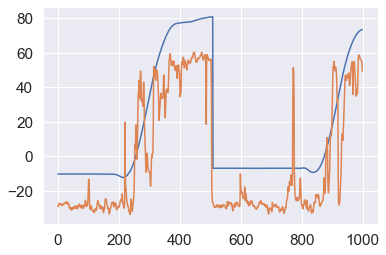

In [134]:

plt.plot(y_valid[:1000,0])
plt.plot(y_valid_predicted_lstm[:1000,0])
plt.show()

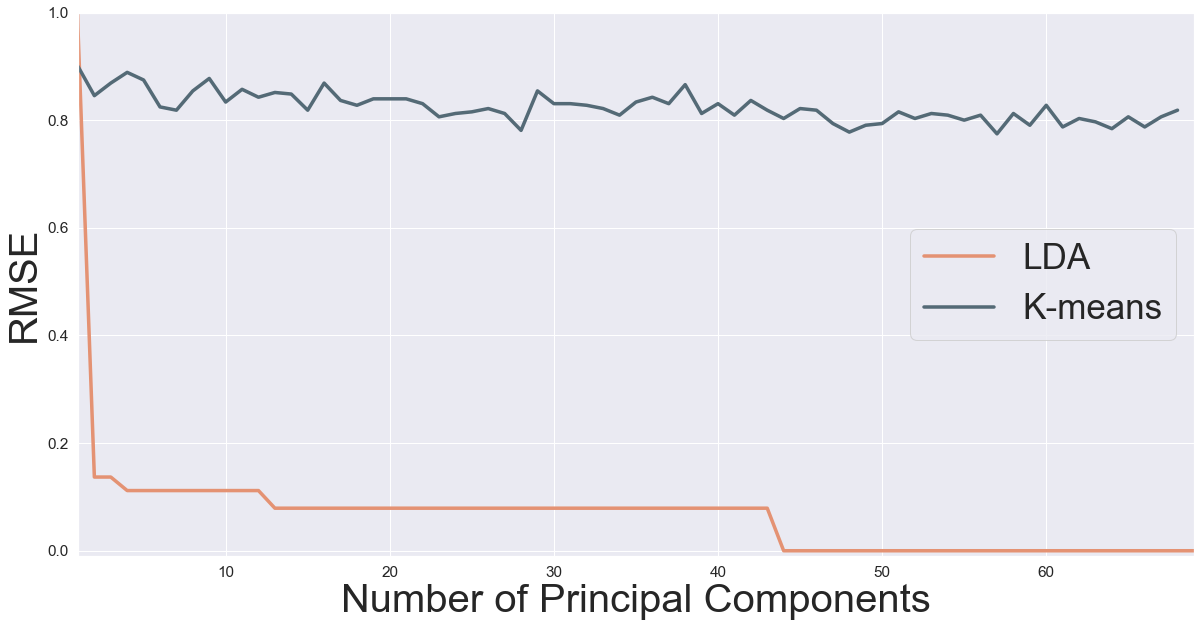

0.0

In [138]:
rmse_lda = scipy.io.loadmat('ldarmse.mat')
rmse_lda = rmse_lda['rmse']

rmse_knn = scipy.io.loadmat('rmse_knn.mat')
rmse_knn = rmse_knn['rmse_test']

plt.figure(figsize=(20,10))
t = np.arange(1,71)
plt.plot(rmse_lda[0][0:70], label = 'LDA', color = '#E49273',linewidth=3.5)
plt.plot(rmse_knn[0], label = 'K-means', color = '#546A76',linewidth=3.5)
plt.legend(loc="center right", fontsize = 35)
plt.xlim(1, 69) 
plt.ylim(-0.01,1) 
plt.ylabel('RMSE', fontsize = 40)
plt.xlabel('Number of Principal Components', fontsize = 40)
plt.show()
rmse_lda[0][44]

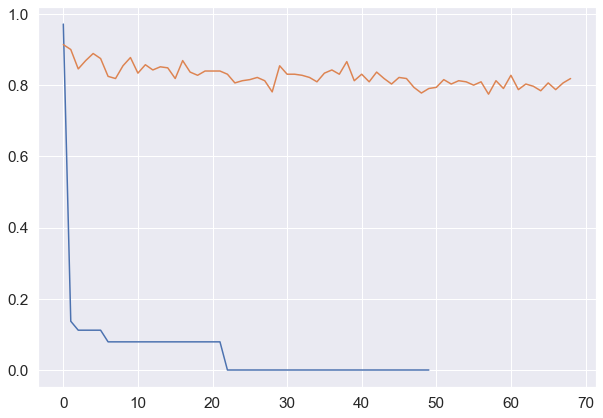

In [12]:
new_list = rmse_lda[0][1::2]
plt.figure(figsize=(10,7))
plt.plot(new_list)
plt.plot(rmse_knn[0])
plt.show()

In [63]:
# rmse values for all directions
x = [32.599087, 20.318615, 8.613735, 26.9343, 26.59185, 9.545, 21.6957, 36.65422]
y = [12.4513729, 4.11365, 3.782818, 4.7378, 2.8546, 5.6329, 4.11298, 11.8326]
x = np.array(x)
y = np.array(y)

In [64]:
x_mean = np.mean(x)
y_mean = np.mean(y)
x_std = np.std(x)
y_std = np.std(y)


<ipython-input-7-20c193fe2588>:14: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  arr.set_xticks(x_mids, x_words)
<ipython-input-7-20c193fe2588>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  arr.set_yticklabels(y_ticks)


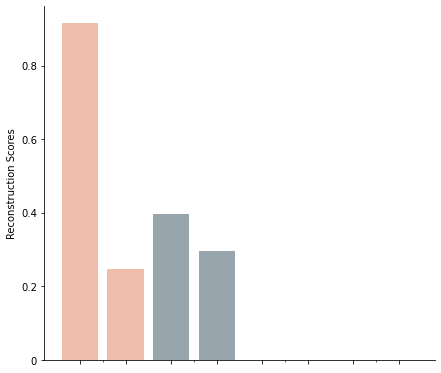

In [7]:

scores = [x_mean, y_mean, 9.891, 7.423, 0, 0, 0, 0]

hatches = ['', '//', '', '//', '', '//', '', '//']
colors = ['#E49273','#E49273','#546A76','#546A76','#8FAD88','#8FAD88','#92374D','#92374D']
f, arr = plt.subplots(1)
f.set_size_inches(7,6.5)
x_pos = np.arange(8)
y_ticks = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
x_mids = [0.5, 2.5, 4.5, 6.5]
x_words = ['LSTM', 'LSBoost', 'CNN', 'KF']

arr.bar(x_pos, scores, color = colors, hatch=hatches, alpha=0.6)

arr.set_xticks(x_mids, x_words)
arr.spines['right'].set_visible(False)
arr.spines['top'].set_visible(False)
arr.set_ylabel('Reconstruction Scores')
arr.set_yticklabels(y_ticks)

arr.tick_params(labelbottom=False)
#leg1 = mpatches.Patch(facecolor = "#808080", alpha=0.2, hatch="", label="poop")
#leg2 = mpatches.Patch(facecolor = "#808080", alpha=0.2, hatch="//", label="NRMSE")

#arr.legend(handles=[leg1, leg2], fontsize=10)

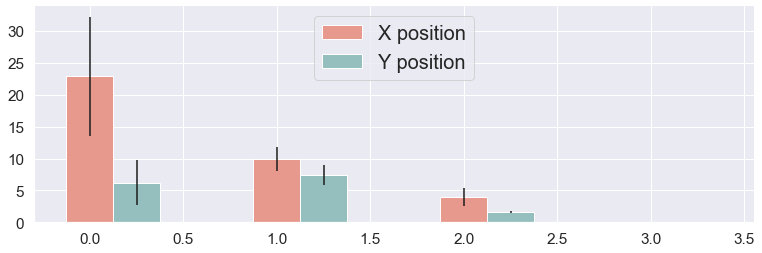

In [75]:
marta_x = np.array([3.59094745, 5.81015221, 5.62032778, 3.37246794, 1.76742651, 5.05108552,
 4.53929242, 2.22579929])
marta_y = np.array([1.47981725, 1.53074478, 1.9938547,  1.83653592, 1.59020225, 1.23882812,
 1.49514159, 1.7214741] )
marta_mean_x = np.mean(marta_x)
marta_mean_y = np.mean(marta_y)
data = [[x_mean, 9.891, marta_mean_x, 0],
[y_mean, 7.423, marta_mean_y, 0]]

X = np.arange(4)
fig = plt.figure(figsize=(10,3))
ax = fig.add_axes([0,0,1,1])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
line1 = ax.bar(X + 0.00, data[0], yerr= [x_std, 1.907, 1.4138139906126113, 0], color = '#E8998D', width = 0.25, label = 'X position')
line2 =ax.bar(X + 0.25, data[1], yerr= [y_std, 1.637, 0.21956374158415257, 0], color = '#94BFBE', width = 0.25, label = 'Y position')

ax.legend(handles=[line1, line2], fontsize = 20,loc="upper center")

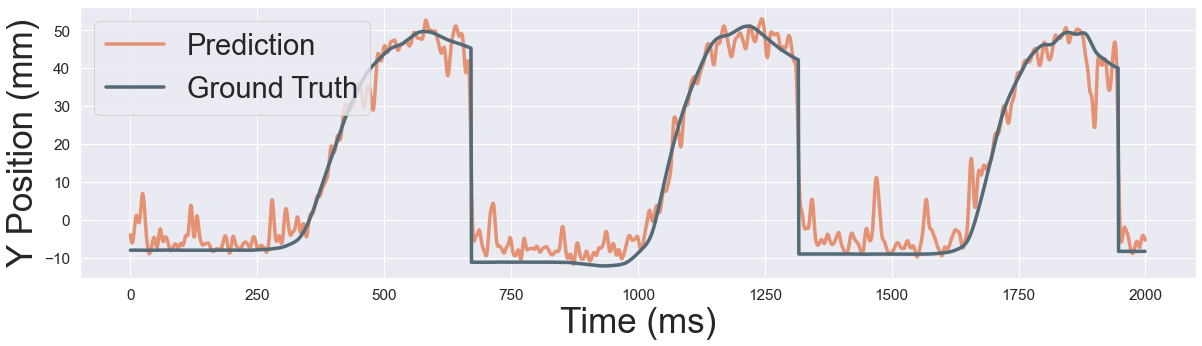

In [137]:
pred = scipy.io.loadmat('pred.mat')
pred2 = pred['smoothed']


truth = scipy.io.loadmat('truth.mat')
truth2 = truth['truth']
plt.figure(figsize=(20,5))
t = np.arange(1,71)
plt.plot(pred2[0:2000], label = 'Prediction', color = '#E49273',linewidth=3.5)
plt.plot(truth2[0:2000], label = 'Ground Truth', color = '#546A76',linewidth=3.5)
#plt.plot(y_valid_predicted_lstm[:2000,1]+y_train_mean[0], label = 'Ground Truth',linewidth=3.5)
plt.legend(loc="upper left", fontsize = 29)

plt.ylabel('Y Position (mm)', fontsize = 35)
plt.xlabel('Time (ms)', fontsize = 35)
plt.show()


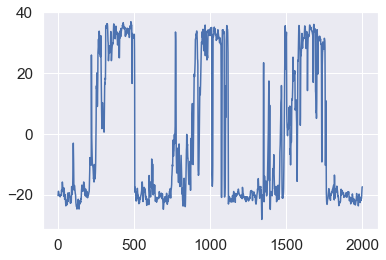

In [131]:
plt.plot(y_valid_predicted_lstm[0:2000,1])

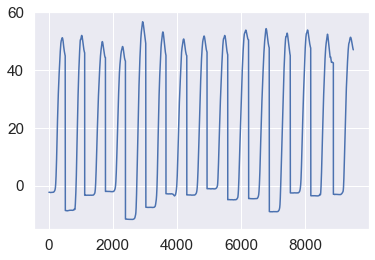

In [123]:
plt.plot(y_valid[:,1])